# Importação das bibliotecas

In [127]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   - -------------------------------------- 4.5/124.9 MB 26.9 MB/s eta 0:00:05
   -- ------------------------------------- 8.4/124.9 MB 21.7 MB/s eta 0:00:06
   ---- ----------------------------------- 12.6/124.9 MB 21.9 MB/s eta 0:00:06
   ----- ---------------------------------- 17.0/124.9 MB 21.5 MB/s eta 0:00:06
   ------ --------------------------------- 21.0/124.9 MB 21.0 MB/s eta 0:00:05
   -------- ------------------------------- 25.7/124.9 MB 21.4 MB/s eta 0:00:05
   --------- ------------------------------ 30.1/124.9 MB 21.3 MB/s eta 0:00:05
   ----------- ---------------------------- 34.6/124.9 MB 21.3 MB/s eta 0:00:05
   ------------ --------------------------- 38.8/124.9 MB 21.3 MB/s eta 0:00:05
   ------------- -------------------------- 42.7/124.9 MB 20.9 MB/s eta 0:00:04
   --------------- ------------------------ 47.2/124.9 MB 20.9 MB/s eta 0:00:04
   ---------------- ----------------------- 51.4/12

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
import time
import os

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from matplotlib import pyplot as plt

# Carregamento dos Dados

- Caminho para o arquivo do dataset

In [2]:
path = '../dataset/notasfiscais.csv'

- Estavam todos concatenados, apenas separados por ';'.

In [3]:
df_bruto = pd.read_csv(path, delimiter=";")

- Apresentação de 10 linhas do dataset

In [4]:
df_bruto.head(10)

,id,issue_date,id_supplier,iss_retention,lc116,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,state,class_label
0,1,2024-10-14 00:00:00.000,7101.0,True,4.03,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,True,PA,valid
1,2,2024-10-16 00:00:00.000,5839.0,True,4.12,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,True,AM,not valid
2,3,2024-10-15 16:40:24.000,974.0,False,10.02,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,False,PA,valid
3,4,2024-10-17 00:00:00.000,9099.0,True,4.03,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,True,PA,valid
4,5,2024-10-07 17:04:16.000,3434.0,False,4.09,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,False,AM,valid
5,6,2024-10-04 00:00:00.000,6668.0,False,4.03,5540.4000,2.500000,0.0,0.0,0.0,0.0,0.00,True,AM,valid
6,7,2024-10-17 00:00:00.000,8788.0,False,4.06,1292.7600,2.000000,0.0,0.0,1.5,3.0,0.65,False,RO,valid
7,8,2024-10-17 00:00:00.000,8788.0,False,4.06,36544.0680,2.000000,0.0,0.0,1.5,3.0,0.65,False,RO,valid
8,9,2024-10-17 15:09:16.000,974.0,False,10.02,26.6817,2.010000,0.0,0.0,0.0,0.0,0.00,False,PA,valid
9,10,2024-10-14 00:00:00.000,10881.0,True,4.03,1112.7255,2.000000,0.0,0.0,0.0,0.0,0.00,True,PA,valid


# Análise de Dados

- Criação de uma cópia para a análise

In [56]:
df = df_bruto.copy()

## Informações sobre o tipo de cada feature

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16843 entries, 0 to 16842
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           16843 non-null  int64  
 1   issue_date                   16843 non-null  object 
 2   id_supplier                  16675 non-null  float64
 3   iss_retention                16843 non-null  bool   
 4   lc116                        16843 non-null  float64
 5   calculated_value             16843 non-null  float64
 6   iss_tax_rate                 16675 non-null  float64
 7   inss_tax_rate                16843 non-null  float64
 8   csll_tax_rate                16843 non-null  float64
 9   ir_tax_rate                  16843 non-null  float64
 10  cofins_tax_rate              16843 non-null  float64
 11  pis_tax_rate                 16843 non-null  float64
 12  opting_for_simples_nacional  16843 non-null  bool   
 13  state           

- 16843 linhas
- 15 features
    - 10 features numéricas
    - 5 categóricas

## Modificações no Dataset
Algumas modificações foram necessárias para ajudar na análise dos dados.

- Conversão da coluna lc116 para String.

In [57]:
df['lc116'] = df['lc116'].astype(str)
df['lc116']

0         4.03
1         4.12
2        10.02
3         4.03
4         4.09
         ...  
16838     1.07
16839    16.01
16840     1.07
16841     4.02
16842    14.01
Name: lc116, Length: 16843, dtype: object

- Remoção da feature ID

In [58]:
df = df.drop('id', axis = 1)

- Separação das features numéricas e categóricas.

In [10]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

cat_cols = df.select_dtypes(include=["object", "bool"]).columns

print("Colunas Numéricas:", list(num_cols))
print("Colunas Categóricas:", list(cat_cols))

Colunas Numéricas: ['id_supplier', 'calculated_value', 'iss_tax_rate', 'inss_tax_rate', 'csll_tax_rate', 'ir_tax_rate', 'cofins_tax_rate', 'pis_tax_rate']
Colunas Categóricas: ['issue_date', 'iss_retention', 'lc116', 'opting_for_simples_nacional', 'state', 'class_label']


## Descrição geral das features numéricas

In [87]:
df.describe()

,id_supplier,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate
count,16675.000000,1.684300e+04,16675.000000,16843.000000,16843.000000,16843.000000,16843.000000,16843.000000
mean,5858.570675,6.026261e+03,2.789753,0.171719,0.497456,0.658386,1.527887,0.331529
std,3165.422598,2.909761e+04,2.323147,1.405455,0.538369,0.790466,1.611165,0.350895
min,6.000000,1.083000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3336.000000,5.700000e+02,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5913.000000,1.710000e+03,2.244185,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8520.500000,4.647954e+03,3.292734,0.000000,1.000000,1.500000,3.000000,0.650000
max,11241.000000,1.133142e+06,100.000000,21.446848,1.993938,2.999645,5.997115,2.930112


## Quantidade de valores ausentes

In [6]:
print(df.isnull().sum())

issue_date                       0
id_supplier                    168
iss_retention                    0
lc116                            0
calculated_value                 0
iss_tax_rate                   168
inss_tax_rate                    0
csll_tax_rate                    0
ir_tax_rate                      0
cofins_tax_rate                  0
pis_tax_rate                     0
opting_for_simples_nacional      0
state                          168
class_label                      0
dtype: int64


## Percentual de valores ausentes

In [89]:
print((df.isnull().sum() / len(df)) * 100)

issue_date                     0.000000
id_supplier                    0.997447
iss_retention                  0.000000
lc116                          0.000000
calculated_value               0.000000
iss_tax_rate                   0.997447
inss_tax_rate                  0.000000
csll_tax_rate                  0.000000
ir_tax_rate                    0.000000
cofins_tax_rate                0.000000
pis_tax_rate                   0.000000
opting_for_simples_nacional    0.000000
state                          0.997447
class_label                    0.000000
dtype: float64


- como nas colunas categóricas, os valores ausentes são cerca de 1% dos dados totais, essas linhas com dados ausentes provavelmente serão removidas.

## Valores únicos para colunas categóricas

In [90]:
print(df[cat_cols].nunique())

issue_date                     9303
iss_retention                     2
lc116                           118
opting_for_simples_nacional       2
state                             5
class_label                       2
dtype: int64


- Não será considerada as datas para análise de dados

In [96]:
cat_cols = cat_cols[1:]

- Valores únicos graficamente para cada coluna

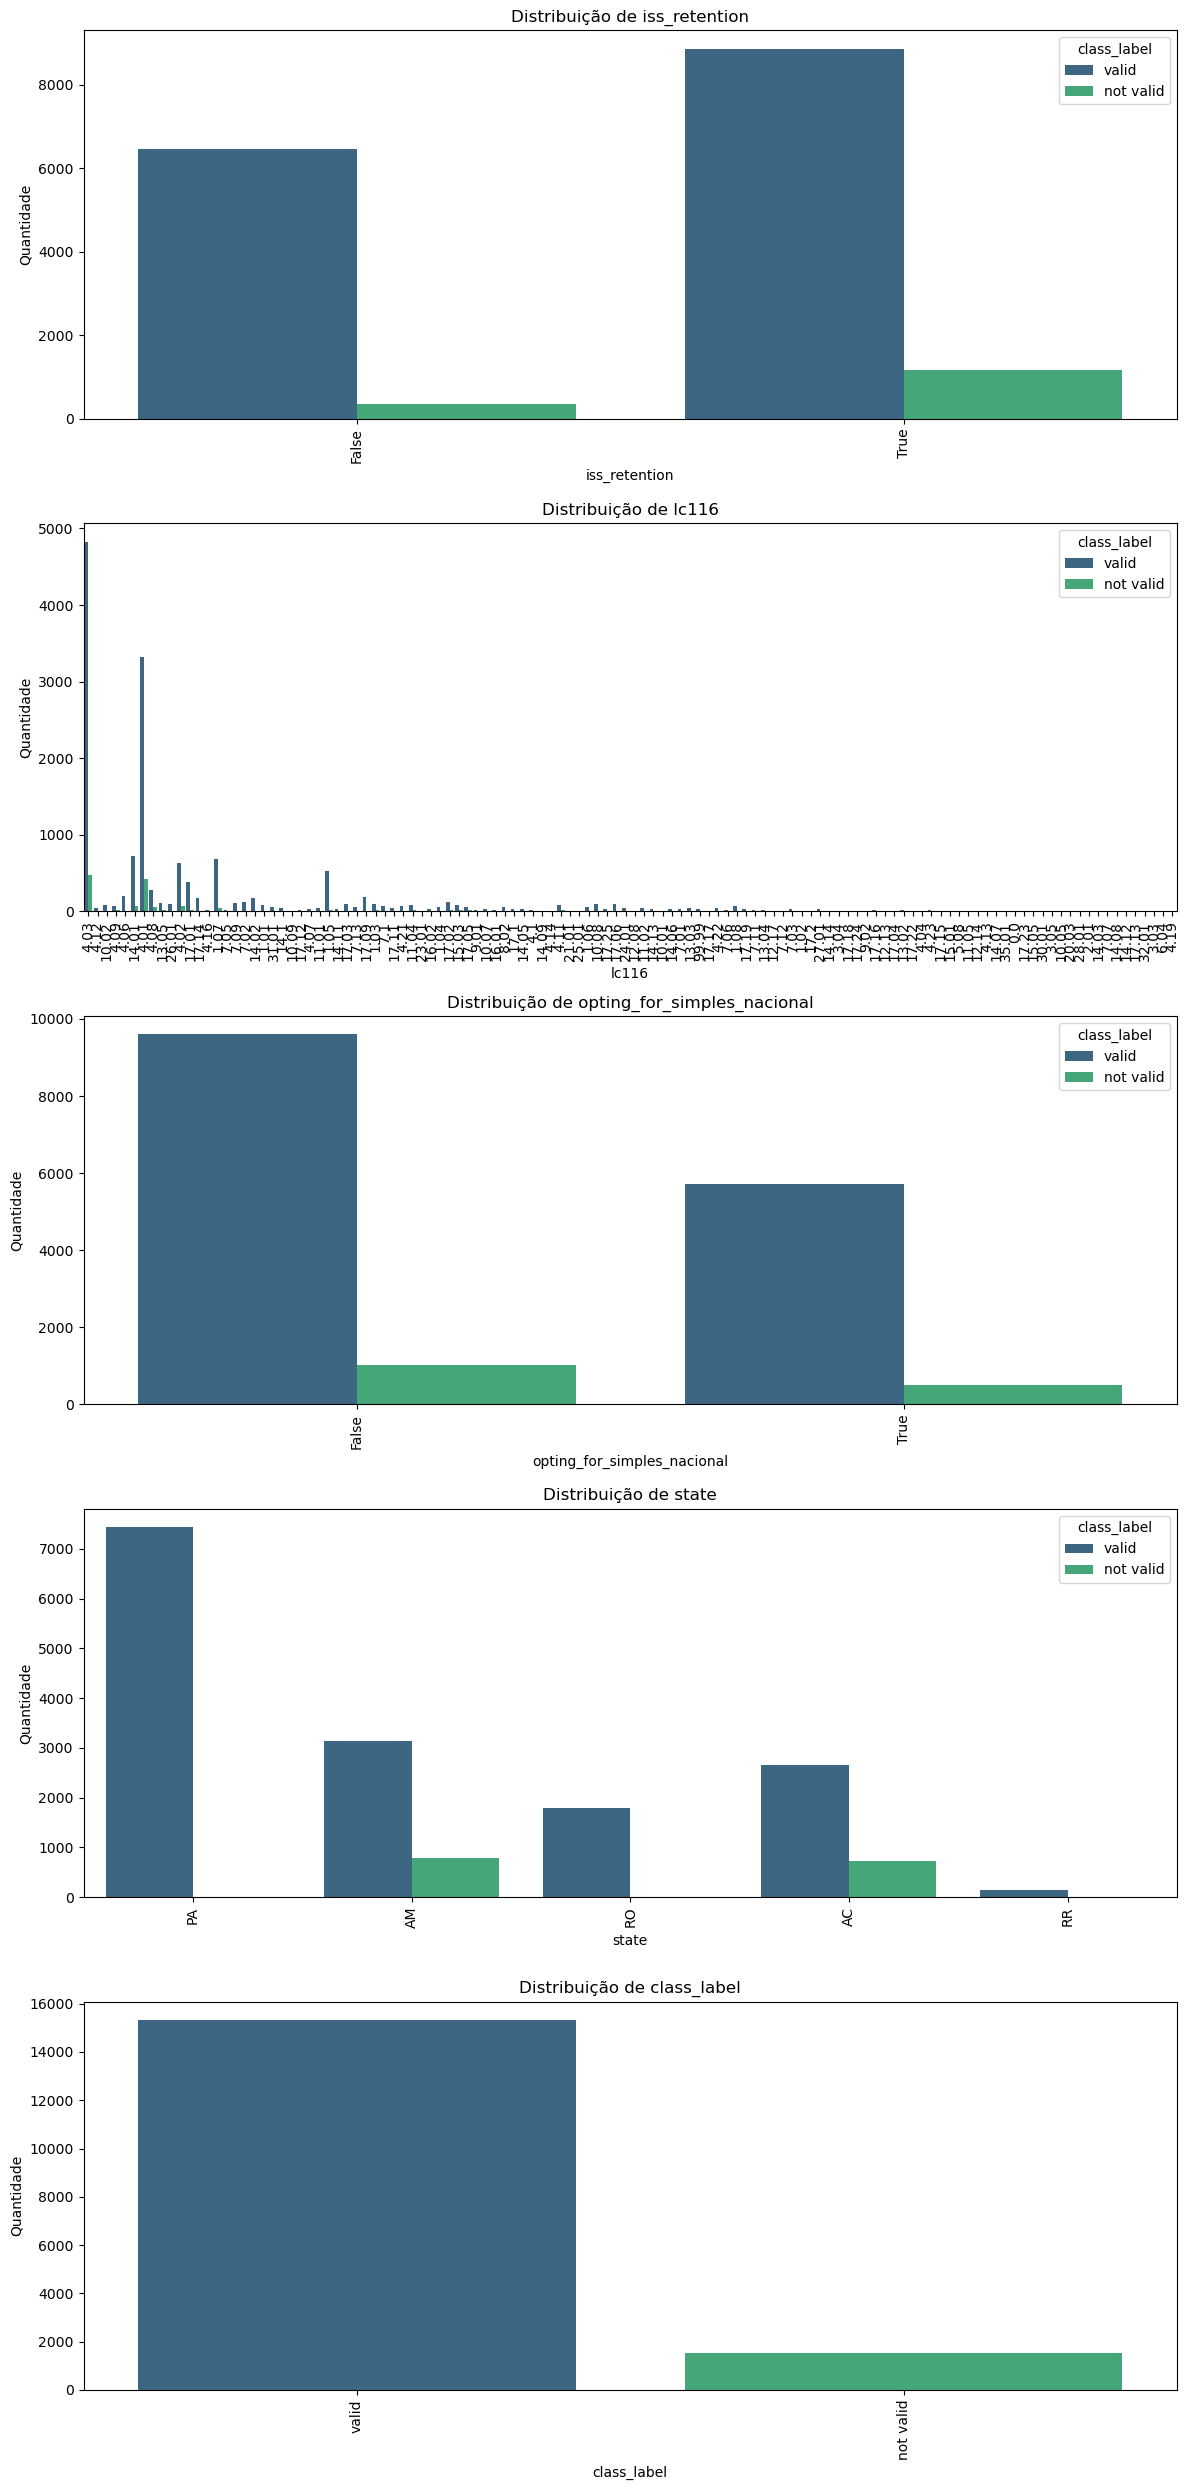

In [74]:
plt.figure(figsize=(12, 5 * len(cat_cols[1:])))

for i, col in enumerate(cat_cols[1:], 1):
    plt.subplot(len(cat_cols[1:]), 1, i)
    sns.countplot(data=df, x=col, palette="viridis", hue="class_label")
    plt.xticks(rotation=90) 
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Quantidade")

plt.tight_layout()
plt.show()

- Verificação da quantidade de itens por rótulos

In [54]:
print(df["class_label"].value_counts())

class_label
valid        15320
not valid     1523
Name: count, dtype: int64


## Relação de Variáveis numéricas e Class Label

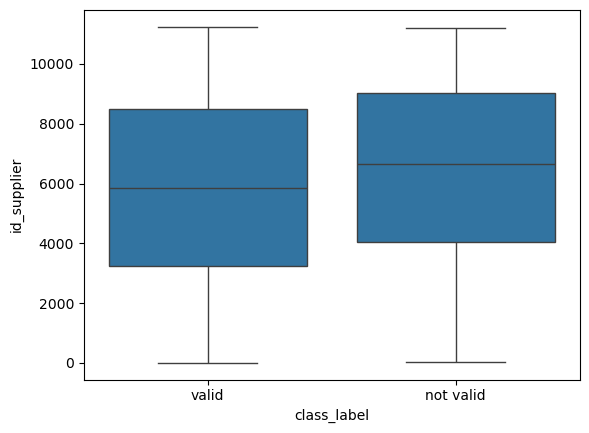

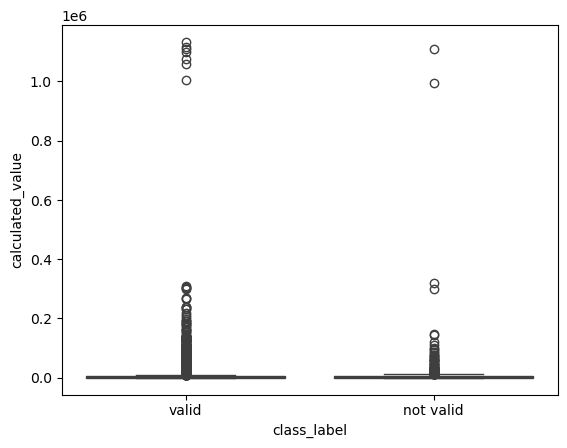

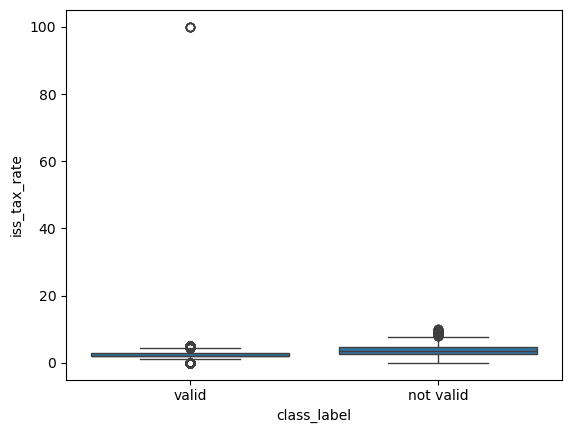

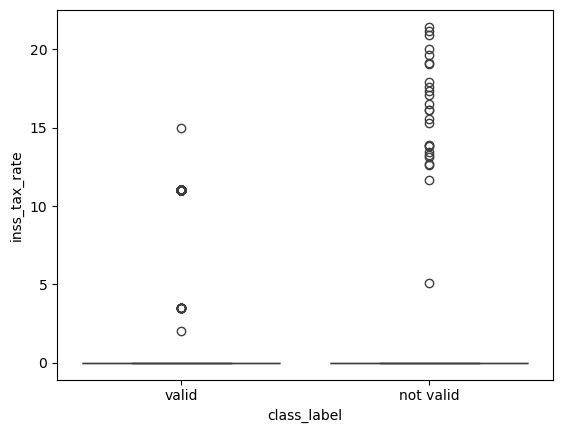

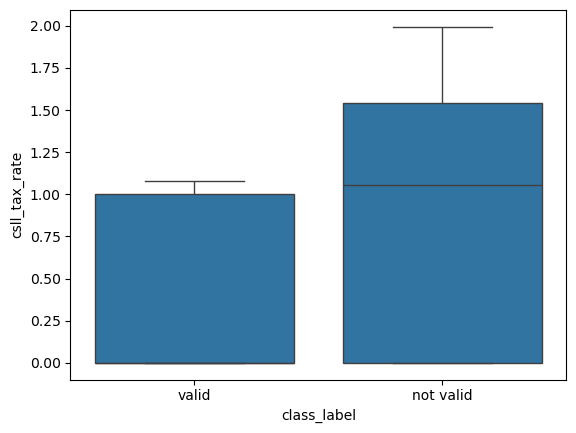

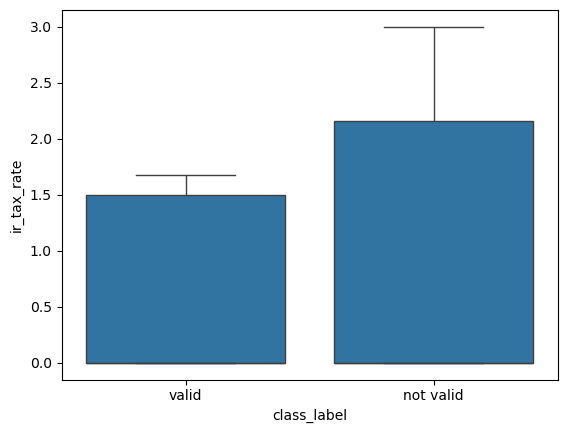

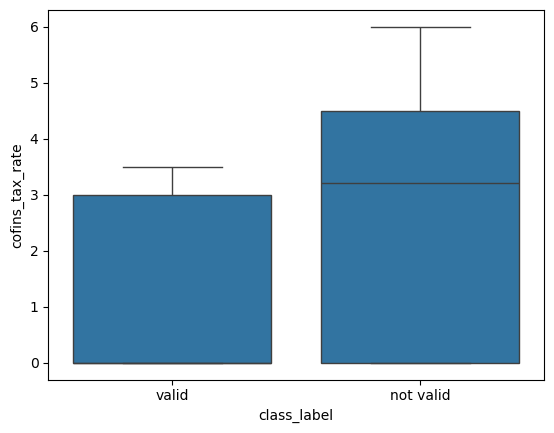

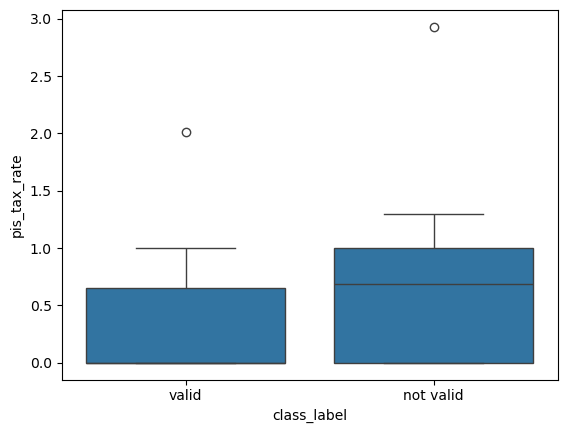

In [82]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols:
    sns.boxplot(x=df["class_label"], y=df[col])
    plt.show()

## Análise da feature Data

In [145]:
def analise_da_data(df_temp, coluna_data):
    df_temp[coluna_data] = pd.to_datetime(df_temp[coluna_data], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")

    df_temp["Ano"] = df_temp[coluna_data].dt.year
    df_temp["Mês"] = df_temp[coluna_data].dt.month
    df_temp["Dia"] = df_temp[coluna_data].dt.day
    df_temp["Hora"] = df_temp[coluna_data].dt.hour
    df_temp["Minuto"] = df_temp[coluna_data].dt.minute
    df_temp["Segundo"] = df_temp[coluna_data].dt.second
    df_temp["Milissegundo"] = df_temp[coluna_data].dt.microsecond // 1000  # Converte microssegundos para milissegundos

    return df_temp.drop('issue_date', axis=1)

df_transformado = analise_da_data(pd.DataFrame(df['issue_date'].copy()), "issue_date")
display(df_transformado)

,Ano,Mês,Dia,Hora,Minuto,Segundo,Milissegundo
0,2024,10,14,0,0,0,0
1,2024,10,16,0,0,0,0
2,2024,10,15,16,40,24,0
3,2024,10,17,0,0,0,0
4,2024,10,7,17,4,16,0
...,...,...,...,...,...,...,...
16838,2025,1,1,8,25,39,0
16839,2025,1,7,18,25,37,0
16840,2025,1,3,12,18,11,0
16841,2025,1,8,7,53,52,0


- Análise de valores válidos de cada parte da data

In [123]:
df_transformado.describe()

,Ano,Mês,Dia,Hora,Minuto,Segundo,Milissegundo
count,16843.000000,16843.000000,16843.000000,16843.000000,16843.000000,16843.000000,16843.0
mean,2024.024521,10.749985,9.167844,7.076708,16.322983,16.016565,0.0
std,0.155811,1.776394,6.679094,6.909886,19.472983,19.356465,0.0
min,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0
25%,2024.000000,10.000000,3.000000,0.000000,0.000000,0.000000,0.0
50%,2024.000000,11.000000,8.000000,8.000000,6.000000,5.000000,0.0
75%,2024.000000,12.000000,14.000000,13.000000,33.000000,31.000000,0.0
max,2025.000000,12.000000,31.000000,23.000000,59.000000,59.000000,0.0


- A partir da análise, os valores de data são válidos, porém não há necessidade dessa feature para o treinamento do modelo, visto que eles não influenciam o valor do rótulo.

## Matriz de correlação

In [59]:
# Transforma o rótulo em número
df["class_label"] = df["class_label"].map({"not valid": 0, "valid": 1})

# Quantifica os valores booleanos
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)

In [60]:
def imprimirMatrizDeCorr(df_temp): # dataframe temporário
    col_nums = df_temp.select_dtypes(include=["int64", "float64", "int32"]).columns
    corr = df_temp[col_nums].corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.show()

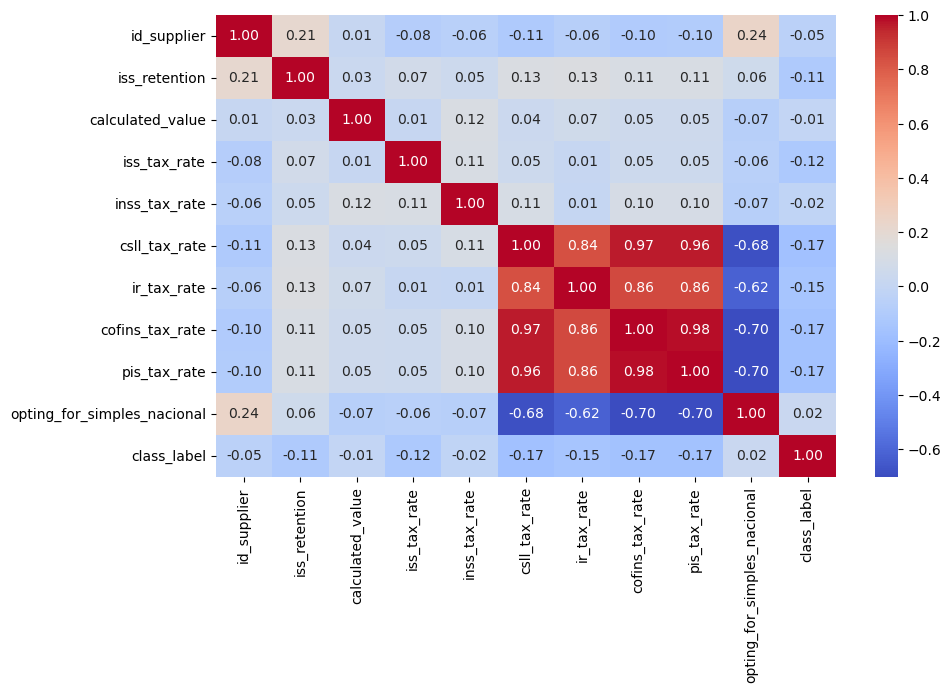

In [61]:
imprimirMatrizDeCorr(df)

- Features cofins_tax_rate, pis_tax_rate e csll_tax_rate estão muito correlacionadas (Multicolinearidade de variáveis).

# Pré-processamento de Dados

- Definição do DataFrame que será utilizado nos modelos (ignora as modificações da análise)

In [5]:
df = df_bruto.copy()

## Limpeza de Dados

- Remoção dos dados faltantes das features categóricas

In [6]:
df = df.dropna(subset=["id_supplier"])

- Visualização dos dados faltantes restantes

Com a remoção das amostras ausentes, os valores ausentes da feature "iss_tax_rate" foram removidos também.

In [7]:
df.isnull().sum()

id                             0
issue_date                     0
id_supplier                    0
iss_retention                  0
lc116                          0
calculated_value               0
iss_tax_rate                   0
inss_tax_rate                  0
csll_tax_rate                  0
ir_tax_rate                    0
cofins_tax_rate                0
pis_tax_rate                   0
opting_for_simples_nacional    0
state                          0
class_label                    0
dtype: int64

## Engenharia de Features

### Remoção das features id, calculated_value, inss_tax_rate, issue_date, lc116 e state

In [8]:
df = df.drop(['id', 'calculated_value', 'inss_tax_rate', 'issue_date', 'lc116', 'state'], axis = 1)
df

,id_supplier,iss_retention,iss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,class_label
0,7101.0,True,2.000000,0.0,0.0,0.0,0.00,True,valid
1,5839.0,True,2.581523,0.0,0.0,0.0,0.00,True,not valid
2,974.0,False,2.000000,0.0,0.0,0.0,0.00,False,valid
3,9099.0,True,3.140000,0.0,0.0,0.0,0.00,True,valid
4,3434.0,False,0.000000,1.0,1.5,3.0,0.65,False,valid
...,...,...,...,...,...,...,...,...,...
16838,11010.0,False,2.000000,0.0,0.0,0.0,0.00,False,valid
16839,6460.0,False,0.000000,0.0,0.0,0.0,0.00,True,valid
16840,769.0,False,2.000000,1.0,1.5,3.0,0.65,False,valid
16841,4822.0,False,2.000000,1.0,1.5,3.0,0.65,False,valid


### Codificação de Variáveis Categóricas

- Codificação de variáveis booleanas

In [9]:
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)
df

,id_supplier,iss_retention,iss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,class_label
0,7101.0,1,2.000000,0.0,0.0,0.0,0.00,1,valid
1,5839.0,1,2.581523,0.0,0.0,0.0,0.00,1,not valid
2,974.0,0,2.000000,0.0,0.0,0.0,0.00,0,valid
3,9099.0,1,3.140000,0.0,0.0,0.0,0.00,1,valid
4,3434.0,0,0.000000,1.0,1.5,3.0,0.65,0,valid
...,...,...,...,...,...,...,...,...,...
16838,11010.0,0,2.000000,0.0,0.0,0.0,0.00,0,valid
16839,6460.0,0,0.000000,0.0,0.0,0.0,0.00,1,valid
16840,769.0,0,2.000000,1.0,1.5,3.0,0.65,0,valid
16841,4822.0,0,2.000000,1.0,1.5,3.0,0.65,0,valid


- Codificação da class_label como booleana

In [10]:
df["class_label"] = df["class_label"].map({"not valid": 0, "valid": 1})
df

,id_supplier,iss_retention,iss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,class_label
0,7101.0,1,2.000000,0.0,0.0,0.0,0.00,1,1
1,5839.0,1,2.581523,0.0,0.0,0.0,0.00,1,0
2,974.0,0,2.000000,0.0,0.0,0.0,0.00,0,1
3,9099.0,1,3.140000,0.0,0.0,0.0,0.00,1,1
4,3434.0,0,0.000000,1.0,1.5,3.0,0.65,0,1
...,...,...,...,...,...,...,...,...,...
16838,11010.0,0,2.000000,0.0,0.0,0.0,0.00,0,1
16839,6460.0,0,0.000000,0.0,0.0,0.0,0.00,1,1
16840,769.0,0,2.000000,1.0,1.5,3.0,0.65,0,1
16841,4822.0,0,2.000000,1.0,1.5,3.0,0.65,0,1


- Verificação dos tipos de variáveis após a codificação de variáveis

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16675 entries, 0 to 16842
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id_supplier                  16675 non-null  float64
 1   iss_retention                16675 non-null  int32  
 2   iss_tax_rate                 16675 non-null  float64
 3   csll_tax_rate                16675 non-null  float64
 4   ir_tax_rate                  16675 non-null  float64
 5   cofins_tax_rate              16675 non-null  float64
 6   pis_tax_rate                 16675 non-null  float64
 7   opting_for_simples_nacional  16675 non-null  int32  
 8   class_label                  16675 non-null  int64  
dtypes: float64(6), int32(2), int64(1)
memory usage: 1.1 MB


## Divisão do Dataset

In [12]:
X = df.drop('class_label', axis=1)
y = df['class_label']

- Divisão do dataset de 70% para treino, 30% teste

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

- Balanceamento dos dados de acordo com os rótulos

In [14]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

- Comparação antes e depois do SMOTE

In [15]:
print(X_train.shape)
print(X_train_res.shape)

(11672, 8)
(21200, 8)


In [16]:
print(y_train.shape)
print(y_train_res.shape)

(11672,)
(21200,)


In [17]:
print(f"Antes do SMOTE: {y_train.value_counts()}")
print(f"Depois do SMOTE: {y_train_res.value_counts()}")

Antes do SMOTE: class_label
1    10600
0     1072
Name: count, dtype: int64
Depois do SMOTE: class_label
1    10600
0    10600
Name: count, dtype: int64


# Modelos de Classificação

- Random Forest: fácil de interpretar, rápido no treino, lida bem com outliers e gera relatório de importância das features.
- XGBoost: Eficientes em dados tabulares, rápido, robusto e gera relatório de importância das features.

## Random Forest

In [18]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

### Importância das Variáveis

In [19]:
importances = rf.feature_importances_
feature_names = X_train.columns

for name, imp in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(name, ":", imp)

iss_tax_rate : 0.30327524934927813
cofins_tax_rate : 0.15775235088551107
pis_tax_rate : 0.1576697642209054
csll_tax_rate : 0.15448340013410478
id_supplier : 0.12646911014346948
ir_tax_rate : 0.0774895177657569
opting_for_simples_nacional : 0.014933120134438446
iss_retention : 0.007927487366535771


## XGBoost

In [20]:
xgb_model = xgb.XGBClassifier(n_estimators=200 ,random_state=42)
xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Importância das Variáveis

<Figure size 1400x1000 with 0 Axes>

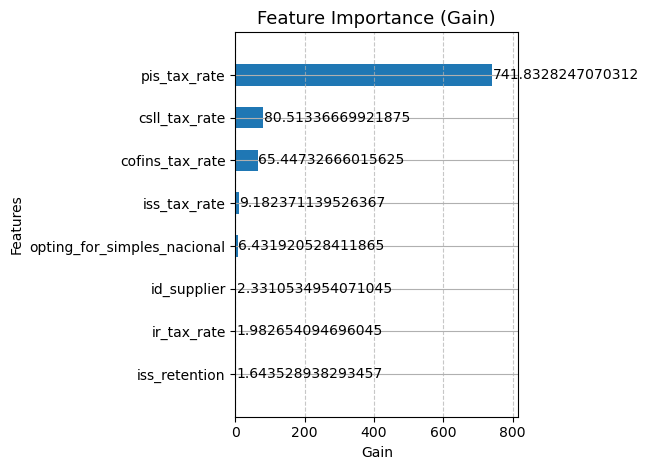

In [21]:
plt.figure(figsize=(14, 10))
ax = xgb.plot_importance(xgb_model, importance_type="gain", height=0.5) 

ax.set_title("Feature Importance (Gain)", fontsize=13) 
ax.set_xlabel("Gain", fontsize=10) 
ax.set_ylabel("Features", fontsize=10)  
ax.tick_params(axis='both', labelsize=10)

plt.grid(axis="x", linestyle="--", alpha=0.7) 
plt.tight_layout()  
plt.show()

# Medição de Latência do Modelo:

- Número de amostras para teste de latência e número de repetições para calcular a média

In [128]:
num_samples = X_test.shape[0]
n_repeticoes = 10  # Número de repetições para calcular a média
num_samples

5003

- Medição de tempo do Random Forest

In [129]:
rf_latencias = []
for _ in range(n_repeticoes):
    inicio = time.perf_counter()
    rf.predict(X_test)
    rf_latencias.append((time.perf_counter() - inicio) / num_samples)

rf_latency_media = np.mean(rf_latencias)
print(f"Latência média do Random Forest: {rf_latency_media:.6f} segundos por amostra")

Latência média do Random Forest: 0.000025 segundos por amostra


- Medição de tempo do XGBoost

In [130]:
xgb_latencias = []
for _ in range(n_repeticoes):
    inicio = time.perf_counter()
    xgb_model.predict(X_test)
    xgb_latencias.append((time.perf_counter() - inicio) / num_samples)

xgb_latency_media = np.mean(xgb_latencias)
print(f"Latência média do XGBoost: {xgb_latency_media:.6f} segundos por amostra")

Latência média do XGBoost: 0.000006 segundos por amostra


# Avaliação dos Modelos

In [23]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)

    prec = precision_score(y_test, y_pred)

    rec = recall_score(y_test, y_pred)

    f1 = f1_score(y_test, y_pred)

    roc_auc = roc_auc_score(y_test, y_proba)

    print("Avaliação do Modelo")
    print("Accuracy       :", round(acc, 3))
    print("Precision      :", round(prec, 3))
    print("Recall         :", round(rec, 3))
    print("F1 Score       :", round(f1, 3))
    print("ROC AUC        :", round(roc_auc, 3))
    print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    return y_pred

## Random Forest

Avaliação do Modelo
Accuracy       : 0.973
Precision      : 0.985
Recall         : 0.986
F1 Score       : 0.985
ROC AUC        : 0.975

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85       436
           1       0.99      0.99      0.99      4567

    accuracy                           0.97      5003
   macro avg       0.92      0.91      0.92      5003
weighted avg       0.97      0.97      0.97      5003



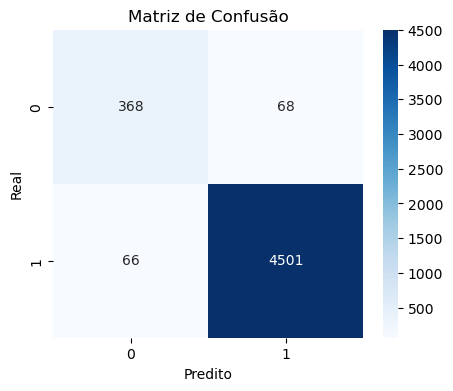

In [24]:
y_pred_rf = evaluate_model(rf, X_test, y_test)

## XGBoost

Avaliação do Modelo
Accuracy       : 0.967
Precision      : 0.986
Recall         : 0.978
F1 Score       : 0.982
ROC AUC        : 0.986

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       436
           1       0.99      0.98      0.98      4567

    accuracy                           0.97      5003
   macro avg       0.89      0.92      0.90      5003
weighted avg       0.97      0.97      0.97      5003



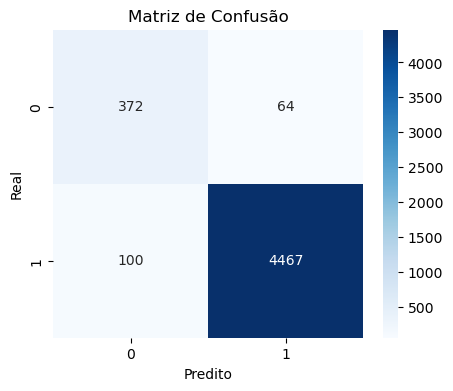

In [25]:
y_pred_xgb = evaluate_model(xgb_model, X_test, y_test)

# Análise dos erros

- Random Forest

In [31]:
df_erros = pd.DataFrame({'Verdadeiro': y_test, 'Previsto': y_pred_rf})
df_erros = pd.concat([pd.DataFrame(X_test), df_erros], axis = 1)
df_erros = df_erros[df_erros['Verdadeiro'] != df_erros['Previsto']]
df_erros.head(10)

,id_supplier,iss_retention,iss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,Verdadeiro,Previsto
16667,8059.0,0,2.916719,0.0,0.0,0.0,0.0,1,0,1
16291,9539.0,1,3.590000,0.0,0.0,0.0,0.0,1,1,0
3288,9512.0,0,0.000000,0.0,0.0,0.0,0.0,1,0,1
15090,1019.0,0,0.000000,0.0,0.0,0.0,0.0,1,1,0
4765,2668.0,1,2.353668,0.0,0.0,0.0,0.0,1,0,1
9398,6820.0,1,3.450000,0.0,0.0,0.0,0.0,1,1,0
2724,10552.0,0,2.740000,0.0,0.0,0.0,0.0,1,1,0
13579,5927.0,1,3.840000,0.0,0.0,0.0,0.0,1,1,0
4821,1647.0,0,0.000000,0.0,0.0,0.0,0.0,1,0,1
13988,9821.0,0,0.000000,0.0,0.0,0.0,0.0,1,0,1


- XGBoost

In [34]:
df_erros = pd.DataFrame({'Verdadeiro': y_test, 'Previsto': y_pred_xgb})
df_erros = pd.concat([pd.DataFrame(X_test), df_erros], axis = 1)
df_erros = df_erros[df_erros['Verdadeiro'] != df_erros['Previsto']]
df_erros.head(10)

,id_supplier,iss_retention,iss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,Verdadeiro,Previsto
16667,8059.0,0,2.916719,0.0,0.0,0.0,0.0,1,0,1
16291,9539.0,1,3.590000,0.0,0.0,0.0,0.0,1,1,0
3288,9512.0,0,0.000000,0.0,0.0,0.0,0.0,1,0,1
15090,1019.0,0,0.000000,0.0,0.0,0.0,0.0,1,1,0
4765,2668.0,1,2.353668,0.0,0.0,0.0,0.0,1,0,1
16497,9552.0,1,2.430000,0.0,0.0,0.0,0.0,1,1,0
2724,10552.0,0,2.740000,0.0,0.0,0.0,0.0,1,1,0
13579,5927.0,1,3.840000,0.0,0.0,0.0,0.0,1,1,0
4821,1647.0,0,0.000000,0.0,0.0,0.0,0.0,1,0,1
13988,9821.0,0,0.000000,0.0,0.0,0.0,0.0,1,0,1


# Experimentos

Foram realizados experimentos: removendo variáveis, alterando valores, normalizando dados, etc.
- Sobre os experimentos, os modelos foram avaliados com:
    - todas as features do dataset.
    - sem as features correlacionadas (cofins_tax_rate, pis_tax_rate e csll_tax_rate).
    - sem features com importância baixa, vistas pelos experimentos anteriores (id, calculated_value, inss_tax_rate, issue_date e lc116).
    - sem o estado.
  
Todos os resultados foram semelhantes: mais de 97% de acerto para cada métrica avaliada. Apesar das métricas terem sidos altas, quando as métricas para cada rótulo foram analisadas, o desbalanceamento se tornou mais evidente, visto que para a classe 0 (not valid) o resultado das métricas recall e f1-score foi um pouco diferente quando comparado com as métricas do rótulo 1 (valid), que era classe majoritária (cerca de mais de 15% de diferença).

## GridSearch

- Uso do GridSearch:
De modo geral, os resultados não apresentaram muita diferença, variava 1% de um rótulo e aumentava 1% do outro. Desse modo, resolvi permanecer sem o GridSearch e utilizando os valores padrões de cada modelo.

- RandomForest no GridSearch:
    - 'n_estimators' : Número de árvores utilizadas.
    - 'max_depth': Profundidade da árvore.
    - 'min_samples_split': Mínimo de amostras para dividir um nó.
    - 'min_samples_leaf': Mínimo de amostras por folha.
    - 'max_features': Número de features por divisão.

- XGBoost no GridSearch:
    - 'n_estimators' : Número de árvores utilizadas.
    - 'max_depth': Profundidade da árvore.
    - 'learning_rate': Taxa de aprendizado.
    - 'subsample': Amostragem dos dados para cada árvore.

In [102]:
def use_grid(model, param_grid, X_train, y_train):
    grid= GridSearchCV(estimator=model,
        param_grid=param_grid,
        scoring='f1_micro', 
        cv=2,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    return grid.best_params_, grid.best_score_, grid.best_estimator_

- Random Forest

In [107]:
param_grid_rf = {
    'n_estimators':[100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}
rf_best_params, rf_best_score, rf_best_estimator = use_grid(RandomForestClassifier(random_state=42), param_grid_rf, X_train, y_train)
print("Melhores parâmetros:", rf_best_params)
print("Melhor score (CV):", rf_best_score)

Fitting 2 folds for each of 108 candidates, totalling 216 fits
Melhores parâmetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Melhor score (CV): 0.9724126113776559


Avaliação do Modelo
Accuracy       : 0.976
Precision      : 0.978
Recall         : 0.996
F1 Score       : 0.987
ROC AUC        : 0.983

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85       436
           1       0.98      1.00      0.99      4567

    accuracy                           0.98      5003
   macro avg       0.96      0.88      0.92      5003
weighted avg       0.98      0.98      0.97      5003



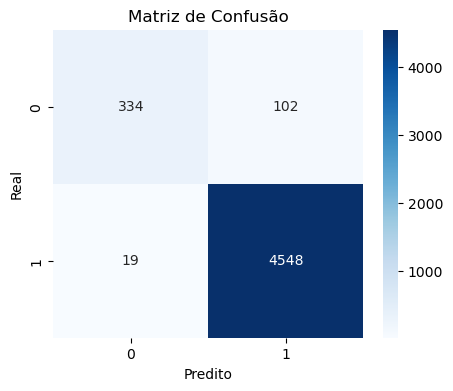

In [108]:
evaluate_model(rf_best_estimator, X_test, y_test)

- XGBoost

In [109]:
param_grid_xgb = {
    'n_estimators':[100, 150, 200],
    'max_depth': [None, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_best_params, xgb_best_score, xgb_best_estimator = use_grid(xgb.XGBClassifier(random_state=42), param_grid_xgb, X_train, y_train)
print("Melhores parâmetros:", xgb_best_params)
print("Melhor score (CV):", xgb_best_score)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Melhor score (CV): 0.9736977381768335


Avaliação do Modelo
Accuracy       : 0.976
Precision      : 0.979
Recall         : 0.995
F1 Score       : 0.987
ROC AUC        : 0.982

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.93      0.78      0.85       436
           1       0.98      0.99      0.99      4567

    accuracy                           0.98      5003
   macro avg       0.96      0.89      0.92      5003
weighted avg       0.98      0.98      0.98      5003



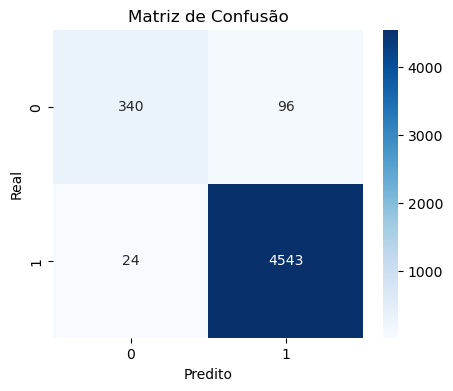

In [111]:
evaluate_model(xgb_best_estimator, X_test, y_test)

# Aplicação do Modelo

 Integração do modelo aos fluxos de trabalho do cliente.

- Criação de uma API para o modelo.
- Ao cadastrar uma nova nota fiscal, a API do modelo é chamada e o resultado é apresentado.
- Se a nota fiscal for inválida, então um alerta é lançado para ser avaliada manualmente.

De modo geral, caso uma nota fiscal seja dita como inválida, será ainda necessário uma verificação manual para garantir a informação. Apesar dessa verificação manual, o modelo consegueria economizar muito tempo classificando as demais notas fiscais.